## 필요한 모듈 불러오기
- urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
- cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
- pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. DeepLab 모델 활용
- pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 이미지 불러오기

In [2]:
# 폴더 내 모든 이미지 불러와서 리스트에 저장
folder_path = os.getenv('HOME')+'/aiffel/project/human_segmentation/images'  

images = []
for image in os.listdir(folder_path):
# png/jpg/jpeg로 끝나는 모든 이미지 불러오기
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        image_path = folder_path + '/' + image
        print(image_path)
        images.append(image_path)

/aiffel/aiffel/project/human_segmentation/images/plane_bright.png
/aiffel/aiffel/project/human_segmentation/images/person_with_umbrella.png
/aiffel/aiffel/project/human_segmentation/images/boat.png
/aiffel/aiffel/project/human_segmentation/images/my_image.png
/aiffel/aiffel/project/human_segmentation/images/people2.png
/aiffel/aiffel/project/human_segmentation/images/table.png
/aiffel/aiffel/project/human_segmentation/images/plane_dark.png
/aiffel/aiffel/project/human_segmentation/images/people.png


(5365, 3577, 3)


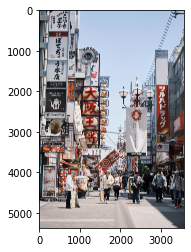

In [12]:
img_path = images[4]
img_orig = cv2.imread(img_path)
print(img_orig.shape)
# 이미지 확인
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## Semantic Segmentation

### 모델 불러오기

In [23]:
# 모델 저장할 경로, 이름 선언
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 deeplabv3+ 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# urlretrieve()를 이용해서 model_url의 파일을 model_file로 다운로드
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/project/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7cd69357eb20>)

In [5]:
#PixelLib 라이브러리에서 가져온 semantic segmentation 클래스의 인스턴스
model = semantic_segmentation() 
# pascal voc로 훈련된 모델 로드
model.load_pascalvoc_model(model_file)

> 주석에 있는 예외 모델이 무슨 뜻이지?  
> 모델 선정 이유: 

### 세그멘테이션 적용

In [13]:
# segmentAsPascalvoc(): 모델을 적용할 이미지의 경로를 입력으로 받고, 세그멘테이션 결과 배열과 이미지 배열 출력
# (overaly 옵션을 사용하면 원본 이미지와 세그멘테이션 결과 output에서 함께 확인할 수 있음)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

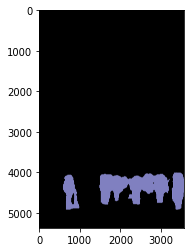

background
person


In [14]:
# 세그멘테이션 결과 확인
plt.imshow(output)
plt.show()
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [15]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 컬러맵에서 15에 해당하는 색상 저장 (person)
seg_color = colormap[15] 
# colormap의 배열은 RGB이고 output의 배열은 BGR이므로 첫번째와 세번째 요소를 서로 바꿈
seg_color[0], seg_color[2] = seg_color[2], seg_color[0]
seg_color = tuple(seg_color)
seg_color

(128, 128, 192)

### 피사체 세그멘테이션 추출
person에 해당하는 부분만 남기기

(5365, 3577)


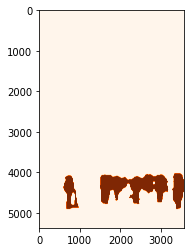

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
# 비행기를 제외한 부분은 모두 동일 색상으로 출력
plt.imshow(seg_map, cmap='Oranges')
plt.show()

채널 정보 사라짐

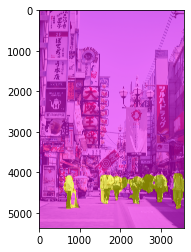

In [17]:
# 원본 이미지를 img_show에 저장
img_show = img_orig.copy()

# 피사체와 배경을 분리한 결과를 img_mask에 저장
# 1과 0인 값을 각각 255과 0으로 바꿔줌
img_mask = seg_map.astype(np.uint8) * 255

# OpenCV의 컬러맵 활용하여 마스크를 다른 색깔로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, 7)

# 원본 이미지와 마스크 일정한 비율(0.5, 0.5)로 섞어서 합치기
img_show = cv2.addWeighted(img_show, 0.5, color_mask, 0.5, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

cf) [OpenCV Color Map](https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html)

## 배경 흐리게 하기

### 전체이미지 블러 처리

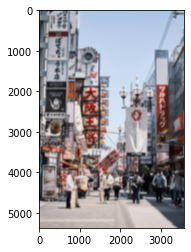

In [19]:
# blur()를 활용해서 원본 이미지 전체를 블러 처리한 이미지 img_orig_blur에 저장 
# 이미지 크기가 클수록 커져야 함
img_orig_blur = cv2.blur(img_orig, (50, 50))

# 흐려진 이미지 확이  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에서 배경만 추출

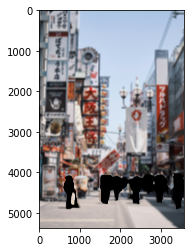

In [20]:
# BGR 형식을 RGB 형식으로 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됨. 피사체가 0이 됨
# 배경 부분은 255
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 블러 처리된 이미지에서 배경 부분만 남김
# bitwise_and()에 의해 피사체 부분은 0이 되기 때문
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린 배경과 피사체 합성

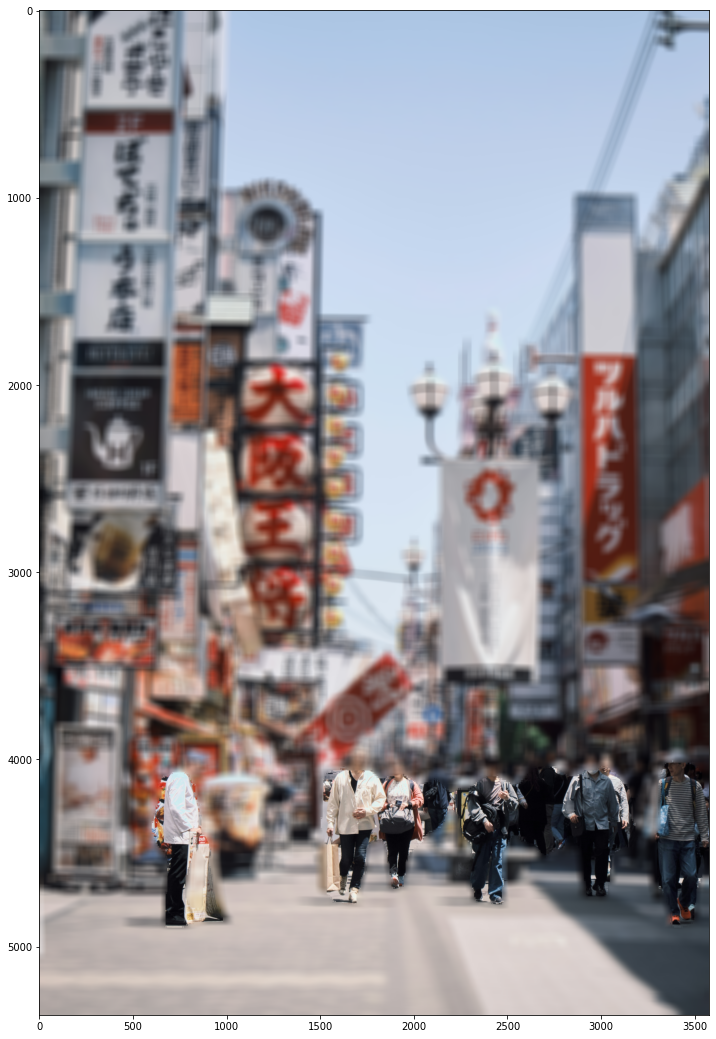

In [21]:
# 세그멘테이션 마스크가 255인 부분(피사체)만 원본 이미지 값을 가지고 오고, 아닌 영역(배경)은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# BGR 형식을 RGB 형식으로 변경
fig = plt.figure(figsize=(12, 20))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 결과 저장

In [22]:
result = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
# 이미지 경로에서 확장자 바로 앞 부분만 남기기
img_name = img_path.split('/')[-1].split('.')[0]
# 결과 이미지를 저장할 경로
save_path = '/aiffel/aiffel/project/human_segmentation/results/'+ img_name + '_with_blur.png'
# imsave()를 활용하여 이미지 저장
plt.imsave(save_path, result)

## 결과 이미지 분석
- 이어폰 줄, 돛대와 같이 가느다란 물체에 대한 인식 능력 떨어짐
- 배경이 복잡하거나 어두울 경우 인식 능력 떨어짐
- 라벨에 없는 물체는 인식하지 못할뿐더러, 라벨에 있는 물체이더라도 일반적인 모양이 아니면 인식하지 못 함
- 비슷한 색이나 재질의 물체가 배경에 있다면 그또한 해당 객체로 인식함
- 옷만 있어도 사람으로 인식하는 경우 있음
- 사람이 들고있는 소품(예: 가방)까지 사람으로 인식하는 능력이 떨어짐
- 같은 라벨의 피사체가 서로 다른 거리에 있을 경우에는 사진이 어색하게 보임

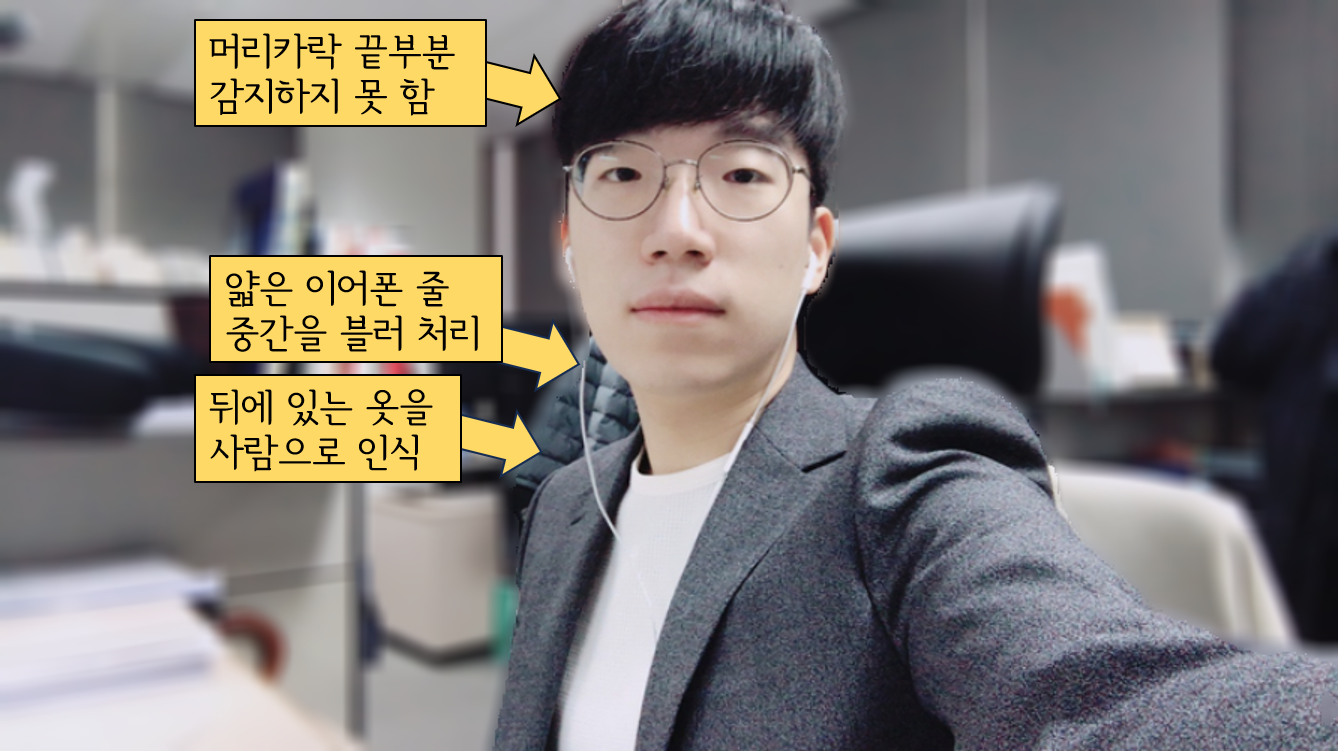

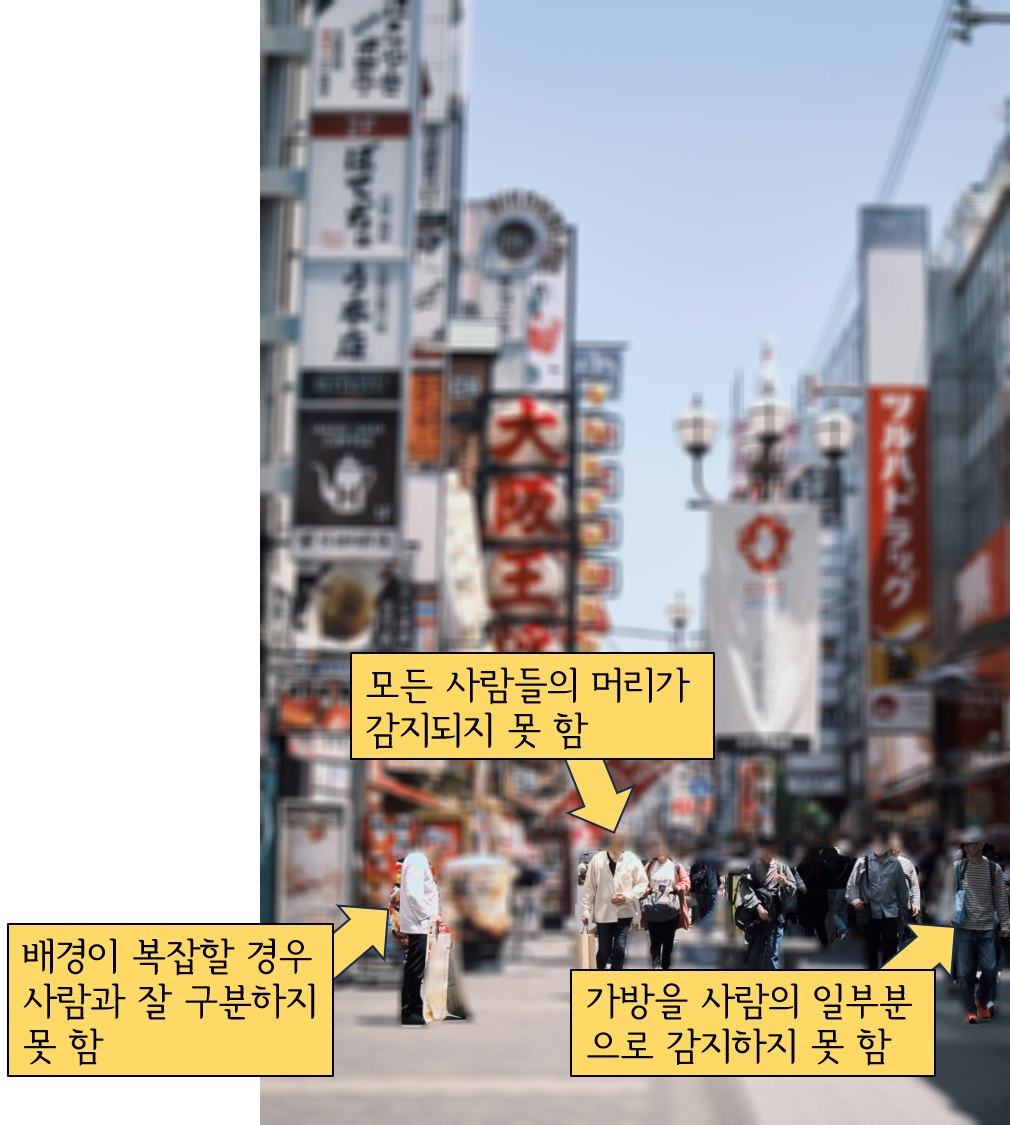

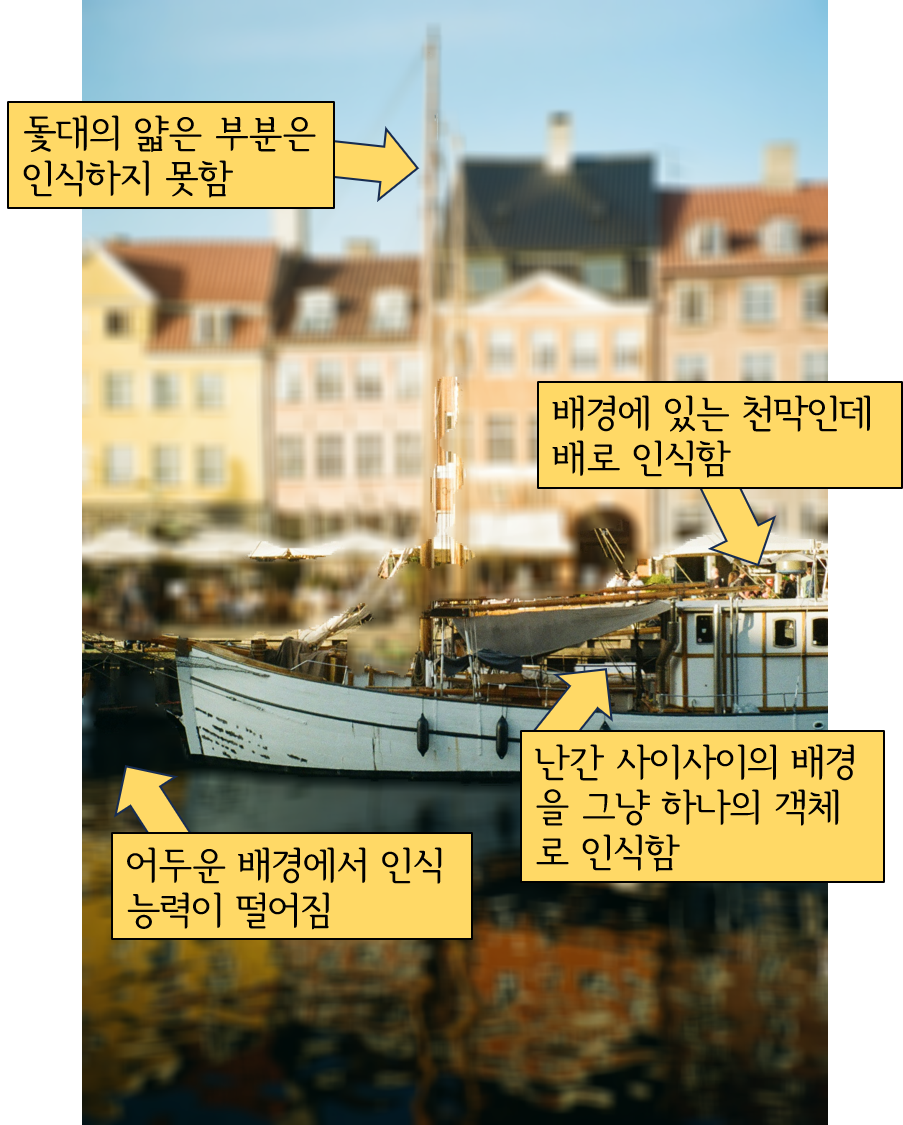

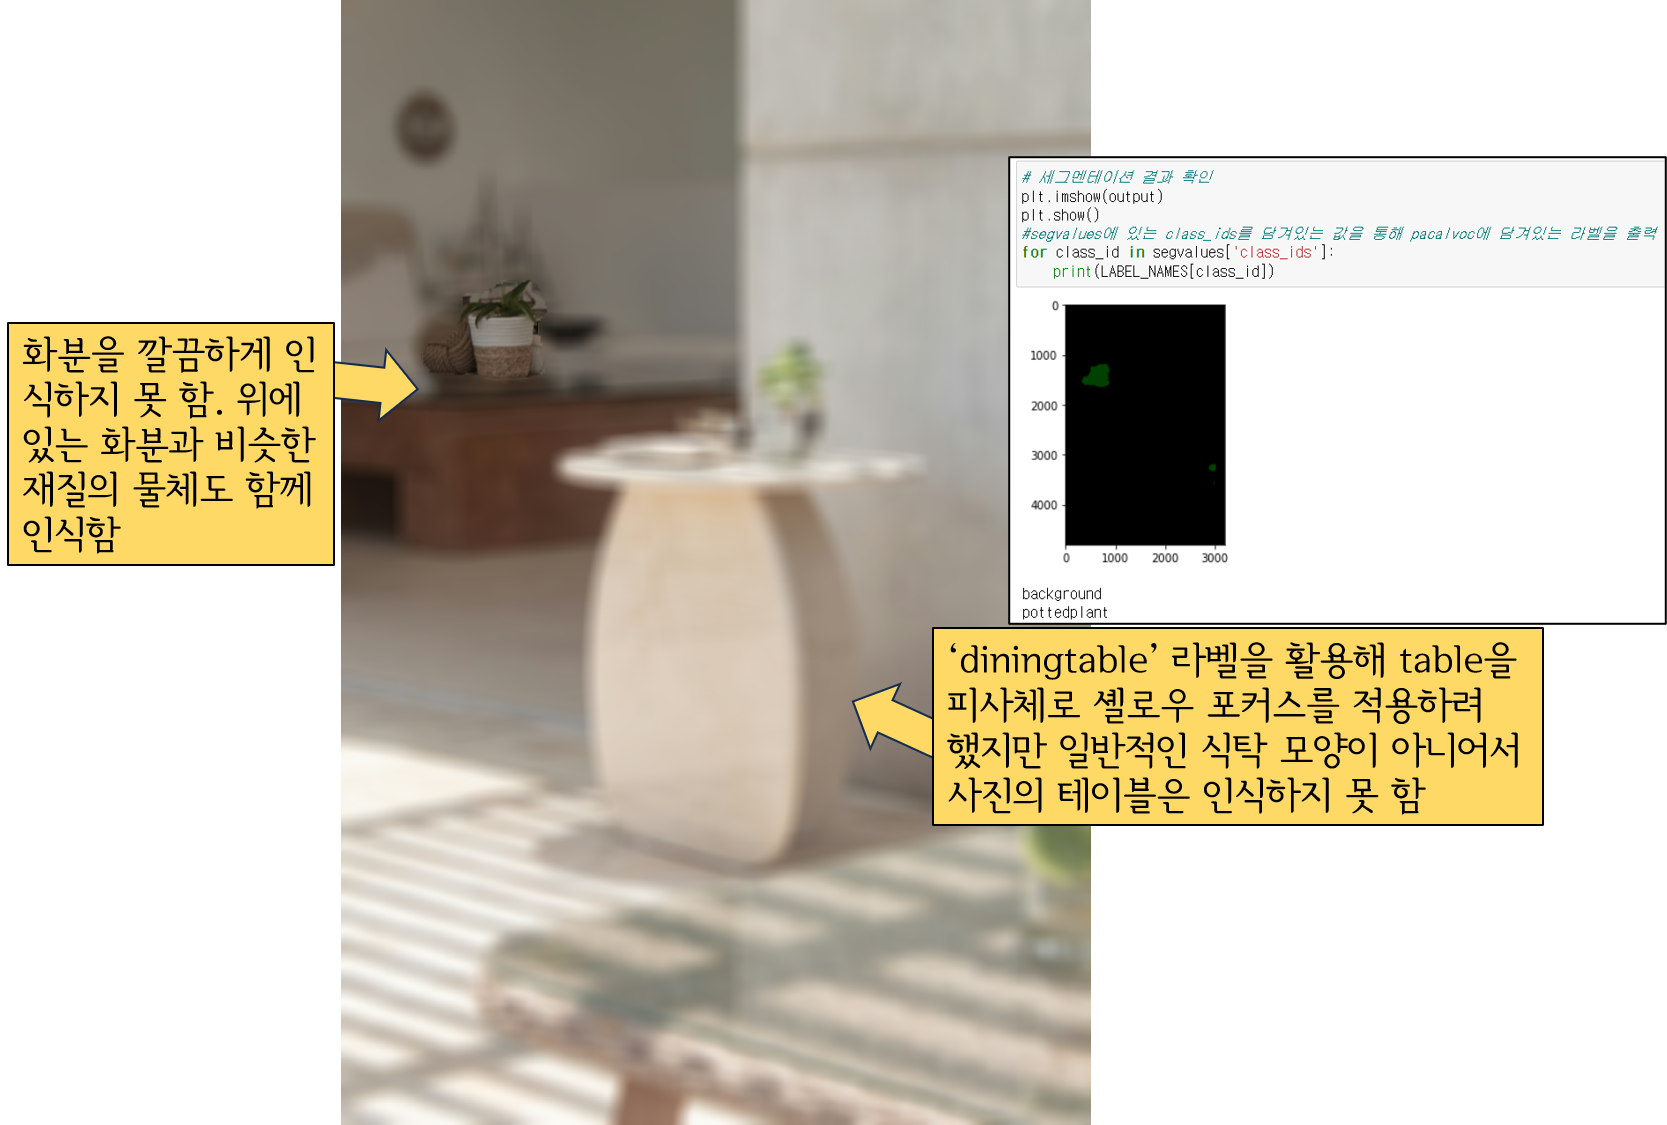